## Debiasing Galaxy Zoo Data

##### Morphological Classification of Galaxy Images from GAMA-KiDS Using Galaxy Zoo

This notebook de-biases a reduced Galaxy Zoo dataset.

In [1]:
# imports
import os
import sys
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar as scalebar
)
from collections import Counter as counter
from scipy.ndimage import gaussian_filter as gauss
import copy
import astropy.stats as stats
import astropy.coordinates as coord
import pandas as pd
import imageio
import time

# LSST stack imports
import lsst
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

# Notebook Startup
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
print(f'Notebook run time: \n   {time.ctime()}')
#--------------------------------68-------------------------------->

Notebook run time: 
   Mon Jun  8 23:01:05 2020


## volume_limiting.ipynb

In [2]:
# Import the required packages #####################################
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from calc_kcor import calc_kcor
import os
import numpy as np
import math

cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # standard astropy cosmol.

data_file = 'full_sample.fits'
data_dir = 'data_dir/'
save_dir = 'save_dir/'
fig_dir = 'figures/samples/'

os.mkdir('figures/') if os.path.isdir('figures/') is False else None

In [3]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

Counter({True: 21441, False: 1688})


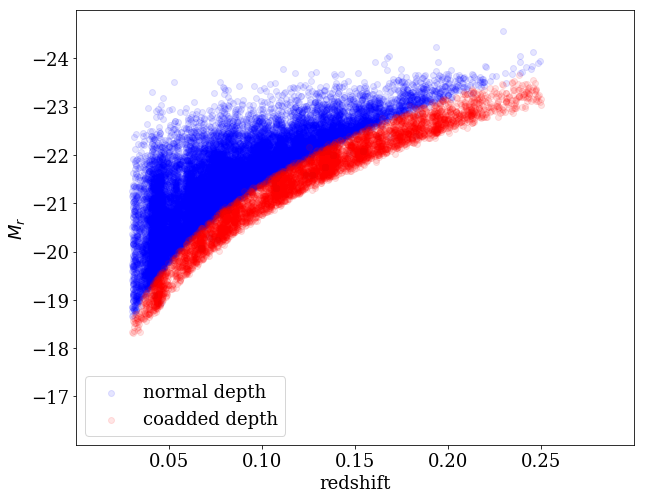

In [4]:
full = Table.read(data_dir + data_file)

print(f'{counter(full["REDSHIFT_1"] >= 0.03)}')

remove_low_z = full['REDSHIFT_1'] >= 0.03 # remove low redshift
full = full[remove_low_z]

s82_select = np.array(['coadd' in s for s in full['sample']]).T
normal_depth = s82_select == False

plt.scatter(full[normal_depth]['REDSHIFT_1'], 
            full[normal_depth]['PETROMAG_MR'], 
            alpha=0.1,color='blue',label='normal depth')
plt.scatter(full[normal_depth == False]['REDSHIFT_1'],
            full[normal_depth == False]['PETROMAG_MR'],
            alpha=0.1,color='red',label='coadded depth')
plt.legend()
plt.xlim(0,0.3)
plt.ylim(-16,-25)
plt.xlabel('redshift')
plt.ylabel('$M_r$')
# Can see here that stripe 82 goes below the m_r=17 selection limit.

full = full[normal_depth] # only keep the normal depth images.

In [5]:
full

dr8objid,dr7objid_1,ra_1,dec_1,rastring,decstring,sample,gz2class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t06_odd_a14_yes_weighted_fraction,t06_odd_a14_yes_debiased,t06_odd_a14_yes_flag,t06_odd_a15_no_count,t06_odd_a15_no_weight,t06_odd_a15_no_fraction,t06_odd_a15_no_weighted_fraction,t06_odd_a15_no_debiased,t06_odd_a15_no_flag,t07_rounded_a16_completely_round_count,t07_rounded_a16_completely_round_weight,t07_rounded_a16_completely_round_fraction,t07_rounded_a16_completely_round_weighted_fraction,t07_rounded_a16_completely_round_debiased,t07_rounded_a16_completely_round_flag,t07_rounded_a17_in_between_count,t07_rounded_a17_in_between_weight,t07_rounded_a17_in_between_fraction,t07_rounded_a17_in_between_weighted_fraction,t07_rounded_a17_in_between_debiased,t07_rounded_a17_in_between_flag,t07_rounded_a18_cigar_shaped_count,t07_rounded_a18_cigar_shaped_weight,t07_rounded_a18_cigar_shaped_fraction,t07_rounded_a18_cigar_shaped_

In [6]:
def get_sample_limits(z,table):
    
    z_max=[z] # Define the maximum redshift.
    # Define the maximum distance from the max redshift.
    D_max=(10**6)*(np.array(cosmo.luminosity_distance(z_max))[0])
    m_limit=17 # Maximum ap. mag. to be used to cut the sample.
    k_val = calc_kcor('r',z,'g - r',0.8)
    M_limit=m_limit - 5*(math.log10(D_max) - 1) - k_val

    return z_max,M_limit

In [7]:
def output_vls_sizes(table,N_steps=1000,z_min=0.03):
    
    z_vals = np.linspace(np.min(table['REDSHIFT_1']),
                         np.max(table['REDSHIFT_1']),
                         N_steps)
    # Replace the value closest to 0.085 with the exact value 
    # (as it is a 'special' value where we have environment data)
    z_vals[find_nearest(z_vals,0.085)] = 0.085
    sizes=np.zeros((N_steps,2))

    for z in enumerate(z_vals):
        z_max,M_limit = get_sample_limits(z=z[1],table=table)
        select = ((table['PETROMAG_MR'] <= M_limit)
                  & (table['REDSHIFT_1'] <= z_max) 
                  & (table['REDSHIFT_1'] >= z_min))
        # & (table['mag'] <= 17))
        sizes[z[0],:] = np.array([z[1],np.sum(select)])
  
    sizes = Table(sizes,names=('redshift','N_gal'))
        
    return sizes

In [8]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def plot_line(max_sample,style,label):
    lines=np.array([[0,max_sample[0],
                     max_sample[0]],
                    [max_sample[1],max_sample[1],0]])
    plt.plot(lines[0],lines[1],style,label=label,linewidth=2)
    return None

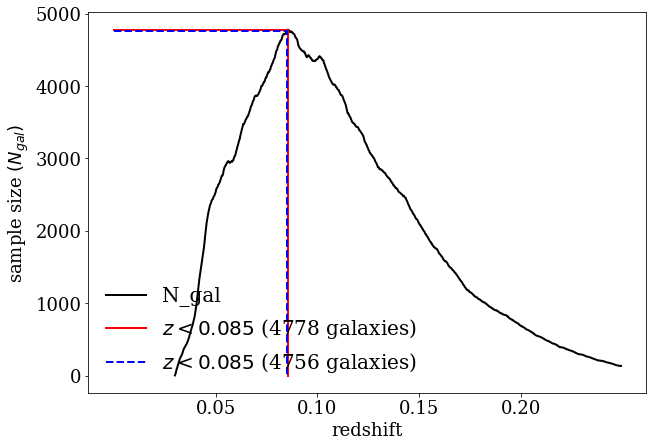

In [9]:
plt.figure(figsize=(10,7))
styles=["b--","g:"]

sizes=output_vls_sizes(table=full,N_steps=1000)
plt.plot(sizes['redshift'],sizes['N_gal'],"k-",linewidth=2)

max_sample=sizes[np.argmax(sizes['N_gal'])]
plot_line(max_sample,"r-",label="$z<{0:.3f}$".format(max_sample[0]) 
          + " ({0:.0f} galaxies)".format(max_sample[1]))

for z in enumerate([0.085]):
    max_sample=sizes[find_nearest(array=sizes['redshift'],
                                  value=z[1])]
    plot_line(max_sample,styles[z[0]],
              label="$z<{0:.3f}$".format(max_sample[0]) 
              + " ({0:.0f} galaxies)".format(max_sample[1]))
    
plt.xlabel('redshift')
plt.ylabel('sample size $(N_{gal})$')
plt.xticks(np.arange(0.05,0.25,0.05))
plt.legend(fontsize=20,frameon=False)

os.mkdir(fig_dir) if os.path.isdir(fig_dir) is False else None
plt.savefig(fig_dir + 'sample_sizes.pdf')

In [10]:
def get_volume_limited_sample(z,full_data,maximise=False,
                              z_min=0.03,plot=None):
    
    if maximise == True:
        sizes = output_vls_sizes(table=full_data)
        z = sizes[np.argmax(sizes['N_gal'])]['redshift']
    
    z_max,M_limit = get_sample_limits(z,full)
    
    select = ((full_data['REDSHIFT_1'] >= z_min) 
               & (full_data['REDSHIFT_1'] <= z_max) 
               & (full_data['PETROMAG_MR'] <= M_limit)
               & (full_data['PETROMAG_R'] <= 17.0)) # Rm 'deep' imgs
    
    if plot is not None:
        
        label_full = ('full sample ($N_{gal}=' 
                      + '{}$)'.format(len(full_data)))
        label_vl = ('luminosity limited sample ($N_{gal}='
                    + '{}$)'.format(np.sum(select)))
        
        plt.figure(figsize=(10,7))
        full_plot = full_data[full_data['PETROMAG_R'] <= 17.0]
        sort = np.arange(0,len(full_plot))
        np.random.shuffle(sort)
        x_scatter = full_plot['REDSHIFT_1'][sort][0:plot]
        y_scatter = full_plot['PETROMAG_MR'][sort][0:plot]
        
        plt.scatter(x_scatter,y_scatter,color='b',marker='.',
                    s=40,alpha=0.75,label=label_full)
        plt.hlines(M_limit,z_min,z_max,'k',linewidth=2,
                   label=label_vl)
        plt.vlines(z_min,M_limit,-25,'k',linewidth=2)
        plt.vlines(z_max,M_limit,-25,'k',linewidth=2)
        
        plt.xlabel('redshift')
        plt.ylabel('$M_r$')
        plt.xlim([0,0.25])
        plt.ylim([-17.5,-24.5])
        plt.legend(loc=4,prop={'size':15})
        
        plt.savefig(fig_dir + 'volume_limited_sample.pdf',dpi=100)

    print('M_r limit = {}, {} galaxies in sample'.format(
        M_limit,np.sum(select)))
    
    return select

M_r limit = -21.006995475499096, 4643 galaxies in sample


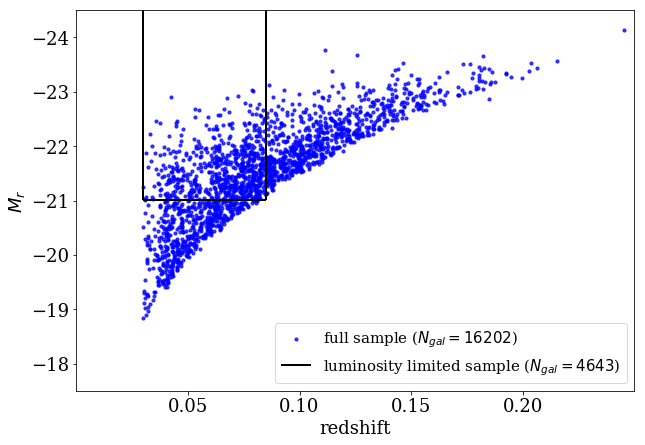

In [11]:
select = get_volume_limited_sample(z=0.085,full_data=full,
                                   z_min=0.03,plot=2000)
vl = full[select]
full['in_volume_limit'] = select # Add col for gals in volume limit.

In [12]:
full.write(save_dir + 'full_sample.fits',overwrite=True)

In [13]:
counter(full['in_volume_limit'])

Counter({True: 4643, False: 11559})

## debiasing_final.ipynb

In [14]:
from __future__ import print_function
from __future__ import division

import os
import math

import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time
from voronoi_2d_binning import voronoi_2d_binning
from sklearn.neighbors import NearestNeighbors
import pickle
import imp # reload modules if necessary

In [15]:
import binning
import bin_debiasing
import fit_debiasing
import make_dictionaries
import params

In [16]:
%matplotlib inline
import matplotlib as mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [17]:
(os.mkdir('output_files/') if os.path.isdir('output_files/') 
 is False else None)

source_directory = params.source_directory
full_sample = params.full_sample

min_log_fv = -1.5
max_log_fv = 0.01

In [18]:
full_data = Table.read(source_directory + 'full_sample.fits')
print('Loaded galaxy data...')

Loaded galaxy data...


In [19]:
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded questions...
Loaded functions...


In [20]:
def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,
                  normalised_values=True):
    ''' Reduce the sample to p>p_cut galaxies only, 
        using the precedeing questions'''
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if normalised_values == True:
        suffix = '_debiased_rh_normalised'
    else:
        suffix = '_debiased_rh'
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_'
                                     + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_'
                           + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(
            len(data_reduced),len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        print('Primary question, so all {} galaxies used.'.format(
            len(data_reduced)))
    
    return data_reduced

In [21]:
def get_bins(question,answer):
    ''' Get bins if they have already been created from a 
        previous running of the debiasing'''
    
    bins = Table.read('output_files/'+ question + '/'
                      + answer + '/bins.fits')
    all_bins = Table.read('output_files/'+ question + '/'
                          + answer + '/all_bins.fits')
    vbins_table = Table.read('output_files/'+ question + '/'
                             + answer + '/vbin_parameters.fits')
    
    vbins = bins['vbin']
    zbins = bins['zbin']
    zbins_coarse = bins['coarse_zbin']
    vbins_all = all_bins['vbin']
    zbins_all = all_bins['zbin']
    zbins_coarse_all = all_bins['coarse_zbin']
    
    return (vbins,zbins,zbins_coarse,vbins_all,zbins_all,
            zbins_coarse_all,vbins_table)

In [22]:
def histogram_fractions(data,hist_bins):
    ''' Get raw histogram values '''
    h,bin_edges = np.histogram(data,bins=hist_bins)
    f = h/np.sum(h)
    return f


def bin_by_column(column, nbins, fixedcount=True):
    ''' Bin the data into redshift slices 
    (or by any column) '''
    
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), 
                                nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins


def get_rms(dataset,reference,redshifts):
    ''' Calculate rms of a dataset in comparison w. ref. data'''
    hist_bins = np.linspace(0,1,11)
    hist_bins[0] = -1
    hist_bins[-1] = 2
    zv,zb = bin_by_column(redshifts,nbins=10)
    
    rms_values = np.zeros(len(np.unique(zb)))
    ref_fractions = histogram_fractions(reference,hist_bins)
    
    for i,z in enumerate(np.unique(zb)):
        
        sample = dataset[zb == z]
        fractions = histogram_fractions(sample,hist_bins)
        rms_values[i] = np.sum((fractions-ref_fractions)**2)
    
    return np.sum(rms_values)

In [23]:
def choose_best_function(raw_data,debiased,question,answer):
    ''' Decide on which set of debiasing values is preferred'''
    volume_ok = raw_data['in_volume_limit'] == 1
    
    # Raw data for reference:
    vl  = raw_data[volume_ok][question + '_' + answer
                              + '_weighted_fraction']
    
    # 2 sets of debiased data for comparison:
    vl_bin = debiased['bin_method'][volume_ok]
    vl_fit = debiased['fit_method'][volume_ok]
    redshifts = full_data['REDSHIFT_1'][volume_ok]
    
    low_z = (redshifts >= 0.03) & (redshifts < 0.035)
    reference = vl[low_z] # raw low-z for comparison
    
    rms_bin = get_rms(vl_bin,reference,redshifts) # get rms values
    rms_fit = get_rms(vl_fit,reference,redshifts) # get rms values
    
    print('rms^2(bin) = {0:.3f}'.format(rms_bin))
    print('rms^2(fit) = {0:.3f}'.format(rms_fit))
    if rms_bin < rms_fit:
        print('---> bin method selected')
        debiased_values = debiased['bin_method']
    else:
        print('---> fit method selected')
        debiased_values = debiased['fit_method'] 
        # Prefer fit method if it 
        # has better rms^2 value.
        
    return debiased_values

In [24]:
def bin_and_debias(full_data,question,questions,answer,
                   bins_exist=False,n_per_bin=100,coarse=False):
    '''Set to 'coarse' to make the fitting only apply to the 
    'coarse binning' of 4 redshift bins per 
    voronoi bin rather than the fully binned data'''
    
    # Create output file folders:
    (os.mkdir('output_files/'+ question) if
     os.path.isdir('output_files/'
                   + question) is False else None)
    (os.mkdir('output_files/'+ question + '/' + answer) if
     os.path.isdir('output_files/'
                   + question + '/' + answer) is False else None)
    
    # Only use the p>0.5 and N>= 5 data for a given question:
    data = reduce_sample(full_data,questions,question)
    
    if bins_exist == True:
        (vbins,zbins,zbins_coarse,
         vbins_all,zbins_all,zbins_coarse_all,
         vbins_table) = get_bins(question,answer)
        print('Bins obtained from previous iteration...')
        
    else:
        (vbins,zbins,zbins_coarse,
         vbins_all,zbins_all,zbins_coarse_all,
         vbins_table) = binning.bin_data(data,full_data,
                                        question,answer,
                                        signal=n_per_bin)
        
    # Save the binning data:
    bin_table = Table([vbins,zbins,zbins_coarse],
                      names=('vbin','zbin','coarse_zbin'))
    all_bin_table = Table([vbins_all,zbins_all,zbins_coarse_all],
                          names=('vbin','zbin','coarse_zbin'))
    bin_table.write('output_files/'+ question + '/'
                    + answer + '/bins.fits',overwrite=True)
    all_bin_table.write('output_files/'+ question + '/'
                        + answer + '/all_bins.fits',overwrite=True)
    vbins_table.write('output_files/'+ question + '/'
                      + answer + '/vbin_parameters.fits',
                      overwrite=True)

    # Debias using the discrete bin method 1st:
    debiased_bin = bin_debiasing.debias(data,full_data,vbins,
                                        zbins,vbins_all,zbins_all,
                                        question,answer)
    # Now debias using the functional fitting method:
    debiased_fit,dout,fit_setup,zbins,fit_vbin_results = fit_debiasing.debias_by_fit(
        data,full_data,vbins,zbins,zbins_coarse,question,answer,
        function_dictionary,min_log_fv,coarse=coarse)
    
    volume_ok = data['in_volume_limit'] == 1    
    vl_data = full_data[volume_ok]
    vl_fit = debiased_fit[volume_ok]
    vl_bin = debiased_bin[volume_ok]

    debiased_table = Table([debiased_bin,debiased_fit],
                           names=('bin_method','fit_method'))
    debiased_table.write('output_files/'+ question + '/' + answer
                         + '/debiased.fits',overwrite=True)
    dout.write('output_files/'+ question + '/' + answer
               + '/fit_results.fits',overwrite=True)
    pickle.dump(fit_setup,open('output_files/'+ question + '/' +
                               answer + '/fit_setup.p', "wb" ))
    
    return debiased_table

In [25]:
full_data

dr8objid,dr7objid_1,ra_1,dec_1,rastring,decstring,sample,gz2class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t06_odd_a14_yes_weighted_fraction,t06_odd_a14_yes_debiased,t06_odd_a14_yes_flag,t06_odd_a15_no_count,t06_odd_a15_no_weight,t06_odd_a15_no_fraction,t06_odd_a15_no_weighted_fraction,t06_odd_a15_no_debiased,t06_odd_a15_no_flag,t07_rounded_a16_completely_round_count,t07_rounded_a16_completely_round_weight,t07_rounded_a16_completely_round_fraction,t07_rounded_a16_completely_round_weighted_fraction,t07_rounded_a16_completely_round_debiased,t07_rounded_a16_completely_round_flag,t07_rounded_a17_in_between_count,t07_rounded_a17_in_between_weight,t07_rounded_a17_in_between_fraction,t07_rounded_a17_in_between_weighted_fraction,t07_rounded_a17_in_between_debiased,t07_rounded_a17_in_between_flag,t07_rounded_a18_cigar_shaped_count,t07_rounded_a18_cigar_shaped_weight,t07_rounded_a18_cigar_shaped_fraction,t07_rounded_a18_cigar_shaped_

In [26]:
question_order = ['t01_smooth_or_features'
                  ,'t02_edgeon'
                  ,'t07_rounded'
                  ,'t03_bar'
                  ,'t04_spiral'
                  ,'t09_bulge_shape'
                  ,'t05_bulge_prominence'
                  ,'t10_arms_winding'
                  ,'t11_arms_number'
                  ,'t06_odd'
                  ,'t08_odd_feature']

for question in question_order:
    answers = questions[question]['answers']
    
    for answer in answers:
        
        #bins_exist = os.path.isfile('output_files/'+ question
        #                            + '/' + answer + '/bins.fits')
        bins_exist = False
        
        print('----------------------------------')
        print('Question to be debiased:',question)
        print('Answer to be debiased:',answer)
        
        # Use smaller bins!
        debiased = bin_and_debias(full_data,question,questions,
                                  answer,bins_exist=bins_exist,
                                  n_per_bin=50,coarse=False)        
        
        deb_vals = choose_best_function(full_data,
                                        debiased,question,answer)
        full_data[question + '_' + answer
                  + '_debiased_rh'] = deb_vals
        
        print('----------------------------------')

    debiased_values = np.array([
        full_data[question + '_' + a
                  + '_debiased_rh'] for a in answers])
    debiased_norm = debiased_values/np.sum(debiased_values,axis=0)
    debiased_norm[np.isnan(debiased_norm)] = 0
    for m in range(len(debiased_norm)):
        full_data[question + '_' + answers[m]
                  + '_debiased_rh_normalised'] = debiased_norm[m]

----------------------------------
Question to be debiased: t01_smooth_or_features
Answer to be debiased: a01_smooth
Primary question, so all 16202 galaxies used.
Bin-accretion...
122  initial bins.
Reassign bad bins...
20  good bins.
Modified Lloyd algorithm...
18  iterations.
Unbinned pixels:  0  /  4008
Fractional S/N scatter (%): 7.5062619771745345
20 voronoi bins
15.85 redshift bins per voronoi bin
All bins fitted! 8.798588752746582s in total
chisq(logistic) = 0.001625581241374824
All bins fitted! 8.89353346824646s in total
chisq(exp. power) = 0.001319034753650394
All bins fitted! 28.497131824493408s in total
Selected functions:------
k: linear(M),linear(R),linear(z)
c: linear(M),log(R),log(z)


/project/lskelvin/sci2020-gamakidsgz/fit_debiasing.py:276: RuntimeWarning: invalid value encountered in log10
  term = constant*np.log10(var)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3332: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/lskelvin/sci2020-gamakidsgz/fit_debiasing.py:394: RuntimeWarning: invalid value encountered in less
  c[c < cmin] = cmin
/project/lskelvin/sci2020-gamakidsgz/fit

rms^2(bin) = 0.268
rms^2(fit) = 0.363
---> bin method selected
----------------------------------
----------------------------------
Question to be debiased: t01_smooth_or_features
Answer to be debiased: a02_features_or_disk
Primary question, so all 16202 galaxies used.
Bin-accretion...
229  initial bins.
Reassign bad bins...
21  good bins.
Modified Lloyd algorithm...
19  iterations.
Unbinned pixels:  0  /  4018
Fractional S/N scatter (%): 9.423822671304022
21 voronoi bins
15.333333333333334 redshift bins per voronoi bin
All bins fitted! 9.368645191192627s in total
chisq(logistic) = 0.002878885166779994
All bins fitted! 9.728355884552002s in total
chisq(exp. power) = 0.0003566371659680706
All bins fitted! 29.253541231155396s in total
Selected functions:------
k: linear(M),linear(R),linear(z)
c: linear(M),linear(R),linear(z)


/project/lskelvin/sci2020-gamakidsgz/fit_debiasing.py:276: RuntimeWarning: invalid value encountered in log10
  term = constant*np.log10(var)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3332: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rms^2(bin) = 0.183
rms^2(fit) = 0.321
---> bin method selected
----------------------------------
----------------------------------
Question to be debiased: t01_smooth_or_features
Answer to be debiased: a03_star_or_artifact
Primary question, so all 16202 galaxies used.
Bin-accretion...
199  initial bins.
Reassign bad bins...
22  good bins.
Modified Lloyd algorithm...
20  iterations.
Unbinned pixels:  0  /  3195
Fractional S/N scatter (%): 9.254972076188427
22 voronoi bins
11.454545454545455 redshift bins per voronoi bin
All bins fitted! 12.025579690933228s in total
chisq(logistic) = 0.0009636791483839479
All bins fitted! 9.973031997680664s in total
chisq(exp. power) = 3.694969952556025e-05
All bins fitted! 22.69837975502014s in total
Selected functions:------
k: linear(M),log(R),exp(z)
c: linear(M),exp(R),exp(z)


/project/lskelvin/sci2020-gamakidsgz/fit_debiasing.py:276: RuntimeWarning: invalid value encountered in log10
  term = constant*np.log10(var)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3332: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/lskelvin/sci2020-gamakidsgz/fit_debiasing.py:392: RuntimeWarning: invalid value encountered in less
  k[k < kmin] = kmin
/project/lskelvin/sci2020-gamakidsgz/fit

rms^2(bin) = 0.014
rms^2(fit) = 0.002
---> fit method selected
----------------------------------
----------------------------------
Question to be debiased: t02_edgeon
Answer to be debiased: a04_yes
8114/16202 galaxies with p>0.5 and N>=5.
Bin-accretion...
113  initial bins.
Reassign bad bins...
25  good bins.
Modified Lloyd algorithm...
22  iterations.
Unbinned pixels:  0  /  1315
Fractional S/N scatter (%): 13.957294749826977


IndexError: boolean index did not match indexed array along dimension 0; dimension is 16202 but corresponding boolean dimension is 8114